In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm
from sklearn.mixture import GaussianMixture

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.gmm.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *

GT rule probs:  tensor([0.4000, 0.4000, 0.2000], grad_fn=<DivBackward0>)
GT Mode 0: [-5. -5. -5.] +/- [1.  1.5 3.5]
GT Mode 1: [5. 5. 5.] +/- [1.25 0.25 0.25]
GT Mode 2: [-2.  0.  2.] +/- [1.  2.  1.5]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

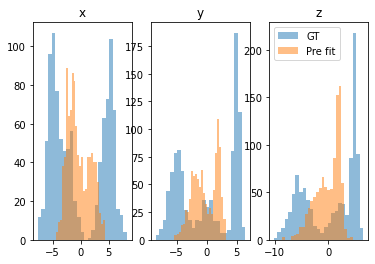

In [74]:
# Make the ground truth GMM grammar.
pyro.set_rng_seed(42)
gt_grammar =SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
root_prototype = Root(gt_grammar.root_node_tf)

# Reset params to values we control (different from prior).
desired_mode_means = [
    torch.tensor([-5., -5., -5.]),
    torch.tensor([5., 5., 5.]),
    torch.tensor([-2., 0., 2.])
]
desired_mode_vars = [
    torch.tensor([1.0, 1.5, 3.5]),
    torch.tensor([1.25, 0.25, 0.25]),
    torch.tensor([1., 2., 1.5])
]
desired_mode_weights = torch.tensor([0.4, 0.4, 0.2])
rule_probs_param = gt_grammar.params_by_node_type["Root"]
rule_probs_param.set(desired_mode_weights)
print("GT rule probs: ", rule_probs_param())
for k, rule_params in enumerate(gt_grammar.rule_params_by_node_type["Root"]):
    mode_name = "Mode_%d" % k
    mean_param = rule_params[0]["mean"]
    mean_param.set(desired_mode_means[k])
    var_param = rule_params[0]["variance"]
    var_param.set(desired_mode_vars[k])
    print("GT Mode %d: %s +/- %s" % (k, mean_param().detach().numpy(), var_param().detach().numpy()))
    
    
# Make our fitting grammar. This'll also have randomly sampled means + vars, but
# different ones.
torch.random.manual_seed(3)
fit_grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
initial_mode_means = [
    torch.tensor([-2., -2., -2.]),
    torch.tensor([2., 2., 2.]),
    torch.tensor([-1., 0., 1.])
]
initial_mode_vars , 1.5, 3.5]),
    torch.tensor([1.25, 0.25, 0.25]),
    torch.tensor([1., 2., 1.5])
]
initial_mode_weights = torch.tensor([0.333, 0.333, 0.333])
rule_probs_param = fit_grammar.params_by_node_type["Root"]
rule_probs_param.set(desired_mode_weights)
for k, rule_params in enumerate(fit_grammar.rule_params_by_node_type["Root"]):
    mode_name = "Mode_%d" % k
    mean_param = rule_params[0]["mean"]
    mean_param.set(initial_mode_means[k])
    var_param = rule_params[0]["variance"]
    var_param.set(initial_mode_vars[k])
#fit_grammar = deepcopy(gt_grammar)
pre_fit_grammar = deepcopy(fit_grammar)

def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)

# Draw random samples from our randomly-initialized GMM
def get_draws_from_grammar(grammar, N_samples):
    samples = []
    for k in tqdm(range(N_samples)):
        tree = grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))
    return samples

gt_samples = get_draws_from_grammar(gt_grammar, 1000)
pre_fit_samples = get_draws_from_grammar(fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_pre_fit = get_all_node_xyzs([sample[0] for sample in pre_fit_samples], Point)
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    plt.hist(l_gt[:, k], bins=25, label="GT", alpha=0.5)
    plt.hist(l_pre_fit[:, k], bins=25, label="Pre fit", alpha=0.5)
    plt.title(label)
    if k == 2:
        plt.legend()

In [3]:
# Try parsing this grammar
pyro.set_rng_seed(42)
test_tree = gt_grammar.sample_tree(detach=True)
print(test_tree.get_root().rules[0].parameters)
test_observed = test_tree.get_observed_nodes()
mip_optimized_trees = infer_mle_tree_with_mip_from_proposals(
    gt_grammar, test_observed, {}, verbose=2, N_solutions=3
)

({'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}, {})
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Wed Jan 12 15:52:14 2022

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 31 rows, 15 columns and 67 nonzeros
Model fingerprint: 0xd1a54dc6
Variable types: 0 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [9e-01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 351.9636972
Presolve removed 30 rows and 12 columns
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Variable types: 0 continuous, 3 integer (3 binary)
Found heuristic solution: objective 21.5640130

Root relaxation: objective 5.302449e+00, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Ga

  0%|          | 0/100 [00:00<?, ?it/s]

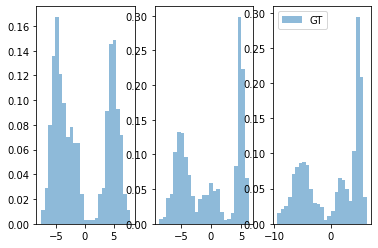

In [4]:
torch.random.manual_seed(43)
N_fit_samples = 100

# Draw an actual fitting dataset.
samples = get_draws_from_grammar(gt_grammar, N_fit_samples)

l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
plt.figure()
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    #plt.hist(l_train[:, k], label="Train", alpha=0.5, bins=25, density=True)
    plt.hist(l_gt[:, k], label="GT", alpha=0.5, bins=25, density=True)
    if k == 2:
        plt.legend()

tensor([0.2995, 0.1439, 0.5566]) [[-0.63322774 -0.16328669  1.52765023]
 [-1.32648068 -1.24129718 -0.10280493]
 [-0.94976312  1.24561478  1.08329222]] [[4.62262509 0.8209086  6.83001399]
 [9.41396026 1.97049415 7.57934202]
 [7.06759619 7.94534282 6.95327399]]
EM fit rule probs:  tensor([0.1999, 0.3301, 0.4700], grad_fn=<DivBackward0>)
EM-fit Mode 0: Parameter containing:
tensor([-2.2439, -0.6126,  1.7560], requires_grad=True) +/- tensor([0.8142, 1.5000, 1.1622], grad_fn=<AddBackward0>)
EM-fit Mode 1: Parameter containing:
tensor([-4.9046, -4.7184, -4.7043], requires_grad=True) +/- tensor([0.7268, 1.8225, 4.4287], grad_fn=<AddBackward0>)
EM-fit Mode 2: Parameter containing:
tensor([4.9814, 5.0070, 5.0496], requires_grad=True) +/- tensor([0.9730, 0.2343, 0.1815], grad_fn=<AddBackward0>)


  0%|          | 0/1000 [00:00<?, ?it/s]

Sampled xyz:  tensor([-1.6634, -1.7398,  0.9489])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([4.1602, 4.1165, 5.3458])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-5.9295, -3.1208, -3.8979])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([6.5629, 5.9340, 4.0820])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-1.8076, -1.0300,  1.6564])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-4.2979, -6.3699, -8.4596])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([3.1594, 5.2255, 4.9571])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500,

Sampled xyz:  tensor([-6.1509, -3.8824, -7.2572])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-1.4156, -2.1946,  2.4959])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-6.5877, -6.2543, -4.0974])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-5.4975, -4.6229, -3.1202])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-2.1365, -2.1672,  4.3314])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-4.4441, -3.7478, -3.9973])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([6.3483, 5.0035, 4.8039])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2

Sampled xyz:  tensor([-1.0796,  0.7588,  1.2712])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([5.2765, 5.3178, 5.8945])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-4.4957, -6.5241, -5.6919])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-5.0594, -5.2847, -8.6005])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([3.8488, 4.6134, 5.0784])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([5.9154, 4.4975, 4.5775])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-6.1202, -5.3311, -5.4278])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000,

Sampled xyz:  tensor([-4.7542, -5.3467, -5.3794])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-2.9896,  1.3987,  0.0293])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([6.0967, 6.0102, 5.0566])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([5.9784, 5.5859, 4.9413])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-1.2710, -1.0040,  3.5027])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([5.6114, 4.6010, 5.3197])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([3.8096, 4.4463, 5.0182])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.250

Sampled xyz:  tensor([3.8713, 5.6940, 5.9095])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([5.5565, 5.3953, 4.9074])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([4.3743, 4.7318, 4.6425])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([7.0363, 5.1539, 4.4684])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([5.9637, 4.2722, 4.1738])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([5.4461, 4.8079, 4.5246])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-4.6638, -6.4586, -4.9664])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled

Sampled xyz:  tensor([-4.6293, -4.6884, -1.7065])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([4.4349, 5.3465, 5.1200])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-2.2066, -1.6300,  1.4685])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-5.4240, -2.7452, -4.9932])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-3.4413, -1.8572, -4.6965])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-1.6862, -0.9143,  0.9184])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-4.6932, -5.5046, -2.3831])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0

Sampled xyz:  tensor([-7.0116, -5.1249, -2.5071])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-1.6593,  3.1403,  1.2760])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-3.6819,  0.9002,  2.0827])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-2.5007,  0.7079,  3.2354])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-5.2507, -5.0492, -4.4231])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([5.2401, 5.1239, 5.0350])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-5.5310, -4.3337, -2.5894])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0

Sampled xyz:  tensor([-3.7701, -6.0055, -5.4363])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-4.1703, -5.5496, -3.6076])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([4.7646, 3.9210, 5.5753])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-3.8700, -5.2351, -9.8148])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([6.1013, 4.9035, 4.2833])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-4.8724, -5.8490, -5.4811])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([4.8533, 5.1915, 5.1894])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500,

Sampled xyz:  tensor([3.2003, 5.0217, 4.7294])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-1.5656,  0.7634,  3.5030])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-1.5362,  2.1182,  3.0071])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-2.9705,  1.0097,  1.9191])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([4.9806, 5.6030, 4.9999])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([5.6364, 4.2846, 4.2310])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([6.4394, 5.0291, 4.6265])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.250

Sampled xyz:  tensor([ -5.0932,  -4.6085, -10.5585])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-4.3567,  0.2245,  0.4279])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-3.2218,  1.7752, -0.3432])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-6.0770, -4.0321, -4.2032])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([3.7183, 5.3283, 5.6924])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-6.1872, -3.4630, -7.4990])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([5.5479, 4.9457, 4.9456])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500

Sampled xyz:  tensor([-4.1360, -6.8128, -7.9044])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-3.5798, -3.6714, -4.3877])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-5.3608, -4.1168, -3.0839])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([5.0479, 5.4260, 5.1849])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-3.5654, -4.1776, -3.7651])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-4.9375, -4.5328, -2.7552])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([3.0001, 4.6986, 5.1121])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0

Sampled xyz:  tensor([6.1162, 5.5306, 5.7119])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-1.7250,  1.7510,  2.0923])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-4.9352, -5.2323, -8.6895])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-4.8254, -4.2419, -6.9048])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-1.7209,  2.0703,  1.9948])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-5.8115, -4.8578, -5.9904])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-6.0202, -5.3597, -5.9203])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0

Sampled xyz:  tensor([6.3980, 5.0714, 4.7039])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-5.0301, -5.0828, -5.4294])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-3.6206, -4.0018, -3.0642])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-3.9905, -4.6527, -6.2259])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([5.3337, 5.1263, 4.7188])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-5.2704, -6.6968, -3.4434])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-2.2955,  0.1343,  2.6581])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2

Sampled xyz:  tensor([-5.7174, -4.7528, -3.2325])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-4.8227, -6.6624, -4.7013])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([7.0624, 5.0626, 4.7623])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-5.7935, -5.5659, -2.8459])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-2.5388,  1.3607,  1.7102])  and my params:  {'mean': tensor([-2.,  0.,  2.]), 'variance': tensor([1.0000, 2.0000, 1.5000])}
Sampled xyz:  tensor([-3.2549, -7.7591, -4.9922])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-3.6400, -3.2168, -3.6820])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0

Sampled xyz:  tensor([5.3016, 5.0439, 4.7012])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-4.0710, -4.1315, -1.8937])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-6.5516, -3.8203, -7.6694])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([4.9009, 4.6357, 5.9812])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([6.8766, 5.0392, 4.5516])  and my params:  {'mean': tensor([5., 5., 5.]), 'variance': tensor([1.2500, 0.2500, 0.2500])}
Sampled xyz:  tensor([-5.2018, -4.1369, -4.1839])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000, 3.5000])}
Sampled xyz:  tensor([-5.4848, -4.0727, -7.3485])  and my params:  {'mean': tensor([-5., -5., -5.]), 'variance': tensor([1.0000, 1.5000,

  0%|          | 0/1000 [00:00<?, ?it/s]

Sampled xyz:  tensor([5.5023, 4.5805, 4.6092])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-3.7276, -2.3312,  1.8633])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([5.9520, 5.3698, 5.5542])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-4.7727, -5.7360, -4.4028])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([3.6949, 4.6843, 4.6877])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-4.3165, -3.8261, -3.4225])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([-4.9577, -4.3847, -2.3556])  and my params

Sampled xyz:  tensor([4.5094, 5.0685, 4.9679])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([4.7271, 3.9096, 5.1019])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.5748, 4.8605, 5.0246])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-4.1042, -5.3392, -0.9197])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([-5.1361, -5.0095, -4.8444])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([4.6930, 4.3849, 5.6585])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([4.5405, 4.7945, 5.0044])  and my params:  {'mean

Sampled xyz:  tensor([5.4456, 3.8030, 4.6984])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.0257, 4.1038, 5.1937])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([6.6318, 4.6541, 5.7152])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.0457, 4.8993, 5.2482])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-4.4082, -2.1347, -3.9440])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([4.2271, 5.7253, 4.6919])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([6.1240, 4.3469, 5.1958])  and my params:  {'mean': ten

Sampled xyz:  tensor([4.7931, 4.8425, 4.4320])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([3.8355, 5.6285, 4.9468])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-2.0396, -0.2644,  3.0069])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([-4.1843, -3.4719, -5.1586])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([5.9223, 4.8676, 4.7646])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.1951, 4.0262, 4.5474])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([4.8178, 4.3007, 5.0883])  and my params:  {'mean

Sampled xyz:  tensor([-3.0551,  0.2083,  1.0700])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([4.3317, 5.7576, 5.2010])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-1.4501, -0.5814,  4.2179])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([4.3365, 4.4612, 5.4603])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.7750, 4.4254, 5.6985])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-4.3669, -6.1768, -6.0296])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([-2.5383,  2.6517,  2.6713])  and my params

Sampled xyz:  tensor([-3.0332, -0.1378, -0.3103])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([-2.6218,  0.5559,  1.8813])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([-5.4196, -2.9286, -5.8322])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([-4.6138, -5.7727, -4.7681])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([4.9249, 4.5348, 4.7394])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([3.0848, 5.1070, 5.0785])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.2933, 5.7131, 5.6366])  and my par

Sampled xyz:  tensor([4.5316, 4.8477, 4.6516])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-6.4557, -5.4820, -1.5518])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([-3.2694, -0.1348,  1.1232])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([4.6509, 5.2084, 4.5965])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([6.2935, 4.9024, 4.7479])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([4.8377, 4.9454, 5.8003])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-2.2593,  0.2841,  2.9841])  and my params:  {'m

Sampled xyz:  tensor([5.0682, 5.5590, 5.4138])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([4.6897, 4.8323, 5.1763])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([4.2854, 4.4591, 4.3876])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.1530, 5.2161, 5.4648])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-2.1287,  0.5879,  2.4030])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([5.0215, 4.8107, 4.8432])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-5.2620, -1.8052, -4.4998])  and my params:  {'mean': 

Sampled xyz:  tensor([4.2573, 3.9978, 5.5533])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-2.7119,  0.5567,  2.9879])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([4.2145, 4.5432, 5.2528])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-5.5261, -4.9866, -7.0019])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([4.0052, 5.0436, 4.2067])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-5.8890, -4.6730, -6.5684])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([-2.9538, -2.2269,  2.3430])  and my params

Sampled xyz:  tensor([5.2980, 4.8390, 5.2083])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.3187, 4.8556, 4.7154])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.3843, 4.7440, 4.9806])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([2.4646, 5.5068, 4.6221])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-4.7690, -3.1671, -4.7198])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([-4.4744, -4.8828, -7.4512])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([ -5.5232,  -6.0058, -10.1860])  and my params:  

Sampled xyz:  tensor([-2.7862,  1.5720,  1.8749])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([6.6395, 5.6644, 5.1084])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([6.1527, 5.5790, 5.3263])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([3.8284, 4.9620, 4.8747])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([4.5822, 4.9888, 4.8871])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-5.0408, -4.6905, -2.8980])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([-5.1359, -4.3071, -3.3114])  and my params:  {'m

Sampled xyz:  tensor([5.1720, 4.6948, 4.2095])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.8730, 5.0521, 5.9562])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.6669, 5.3514, 4.6613])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([3.0669, 4.7285, 4.8707])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([4.9639, 4.5325, 4.6566])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.5894, 4.6613, 5.4437])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-3.3688,  0.9972,  1.3059])  and my params:  {'mean': tensor

Sampled xyz:  tensor([4.4907, 5.0831, 5.0069])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-5.1539, -6.3814, -7.1695])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([5.1261, 4.4198, 5.0852])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-4.8590, -2.6067, -1.3816])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([-3.5111, -1.3360,  2.6056])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([-5.4553, -5.1867, -8.1167])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([-4.5979, -5.1681, -4.6984])  and my 

Sampled xyz:  tensor([-3.7810,  0.4252,  1.5649])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([-4.2731, -5.7361, -2.1064])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([4.5955, 4.0361, 4.8118])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-1.5199, -2.1974,  0.4727])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([-2.1510, -0.6534,  1.7473])  and my params:  {'mean': tensor([-2.2439, -0.6126,  1.7560]), 'variance': tensor([0.8142, 1.5000, 1.1622])}
Sampled xyz:  tensor([5.3715, 4.7330, 5.3173])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.9911, 5.4295, 5.1357])  and my par

Sampled xyz:  tensor([-4.9561, -3.3577, -1.7426])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([6.1706, 4.5878, 5.5301])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.1045, 5.4575, 4.5652])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([4.8109, 5.2102, 5.2377])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([5.1346, 5.0157, 4.9955])  and my params:  {'mean': tensor([4.9814, 5.0070, 5.0496]), 'variance': tensor([0.9730, 0.2343, 0.1815])}
Sampled xyz:  tensor([-4.0425, -2.8530, -7.4069])  and my params:  {'mean': tensor([-4.9046, -4.7184, -4.7043]), 'variance': tensor([0.7268, 1.8225, 4.4287])}
Sampled xyz:  tensor([-4.6155, -6.4444, -6.9430])  and my params:  {'m

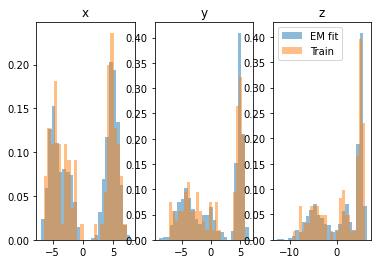

In [5]:
# Hand-written EM baseline for GMM: estimate cluster
# association weights, and then apply a closed form update
# to get new best cluster mean and vars. (Like a "soft"
# k-mean.)
    
# Initialize param guesses from pre-fit grammar
weights_init = pre_fit_grammar.params_by_node_type["Root"]().detach()
means_init = []
vars_init = []
for rule_params in pre_fit_grammar.rule_params_by_node_type["Root"]:
    mean = rule_params[0]["mean"]().detach()
    var = rule_params[0]["variance"]().detach()
    means_init.append(mean)
    vars_init.append(var)
means_init = np.stack(means_init)
vars_init = np.stack(vars_init)
print(weights_init, means_init, vars_init)

gmm = GaussianMixture(
    n_components=3,
    covariance_type="diag",
    weights_init=pre_fit_grammar.params_by_node_type["Root"]().detach(),
    means_init=means_init,
    precisions_init=1./vars_init
)

X = points = torch.stack([sample[1][0].translation for sample in samples])
gmm.fit(X)

# Make an EM-fit grammar with those params
em_fit_grammar = deepcopy(pre_fit_grammar)
rule_probs_param = em_fit_grammar.params_by_node_type[Root.__name__]
rule_probs_param.set(torch.tensor(gmm.weights_))
print("EM fit rule probs: ", rule_probs_param())
for k, rule_params in enumerate(em_fit_grammar.rule_params_by_node_type["Root"]):
    mean_param = rule_params[0]["mean"]
    var_param = rule_params[0]["variance"]
    mean_param.set(torch.tensor(gmm.means_[k, :]))
    var_param.set(torch.tensor(1./gmm.precisions_[k, :]))
    print("EM-fit Mode %d: %s +/- %s" % (k, mean_param(), var_param()))
    
# Draw its empirical fit
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
em_fit_samples = get_draws_from_grammar(em_fit_grammar, 1000)
l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
l_em_fit = get_all_node_xyzs([sample[0] for sample in em_fit_samples], Point)
l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
for k, label in enumerate("xyz"):
    plt.subplot(1, 3, k+1)
    #plt.hist(l_gt[:, k], bins=100, label="GT", alpha=0.5, density=True)
    plt.hist(l_em_fit[:, k], bins=25, label="EM fit", alpha=0.5, density=True)
    plt.hist(l_train[:, k], bins=25, label="Train", alpha=0.5, density=True)
    plt.title(label)
    if k == 2:
        plt.legend()

# One-shot parsing with MAP point latent estimates

In [6]:
# Do single-shot fitting of grammar params based on just the optimal parses
one_shot_fit_grammar = deepcopy(pre_fit_grammar)
em = EMWrapper(one_shot_fit_grammar, [sample[1] for sample in samples],
               parsing_strategy="ip_noproposals", do_nlp_refinement=False
)
em.do_iterated_em_fitting(em_iterations=10, tqdm=tqdm, N_solutions=3, num_workers=10);

EM Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Final params:  tensor([0.1999, 0.3301, 0.4700])
mean tensor([[-0.6332, -0.1633,  1.5277],
        [-2.2261, -0.3763,  1.7992],
        [-2.3253, -0.5585,  1.6169],
        [-2.2879, -0.6882,  1.6340],
        [-2.2438, -0.6126,  1.7560],
        [-2.2439, -0.6126,  1.7560],
        [-2.2439, -0.6126,  1.7560],
        [-2.2439, -0.6126,  1.7560],
        [-2.2439, -0.6126,  1.7560],
        [-2.2439, -0.6126,  1.7560],
        [-2.2439, -0.6126,  1.7560]])
0:xyz:mean final: tensor([-2.2439, -0.6126,  1.7560])
variance tensor([[4.6226, 0.8209, 6.8300],
        [0.6847, 1.1285, 1.5196],
        [0.4811, 1.2508, 0.8837],
        [0.7866, 1.4193, 0.9127],
        [0.8142, 1.5000, 1.1621],
        [0.8142, 1.5000, 1.1622],
        [0.8142, 1.5000, 1.1622],
        [0.8142, 1.5000, 1.1622],
        [0.8142, 1.5000, 1.1622],
        [0.8142, 1.5000, 1.1622],
        [0.8142, 1.5000, 1.1622]])
0:xyz:variance final: tensor([0.8142, 1.5000, 1.1622])
mean tensor([[-1.3265, -1.2413, -0.1028],
    

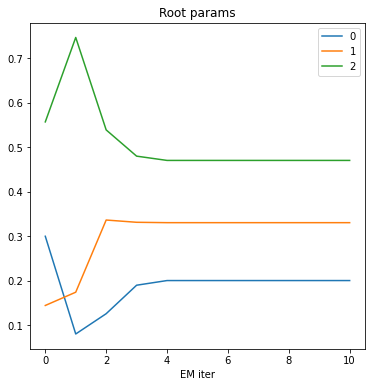

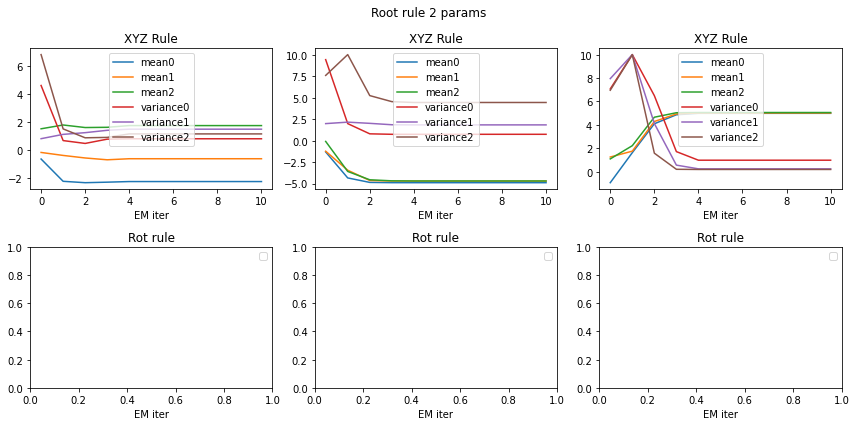

In [7]:
em.plot_grammar_parameter_history(Root)

  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'one_shot_fit_grammar' is not defined

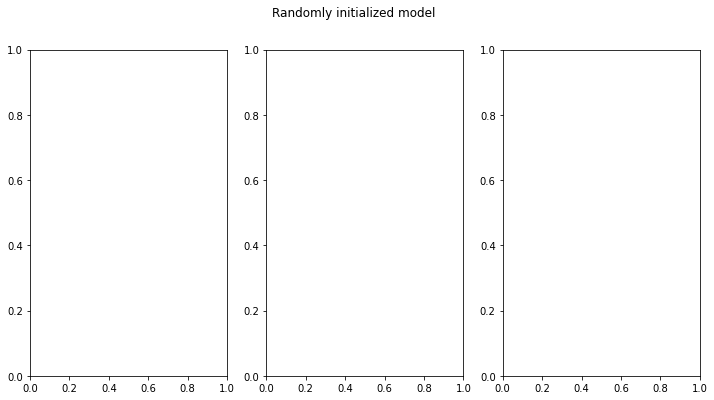

In [55]:
%matplotlib inline
gt_samples = get_draws_from_grammar(gt_grammar, 1000)
def make_figure_for_grammar(one_shot_fit_grammar, axs, N=1000):
    rule_probs_param = one_shot_fit_grammar.params_by_node_type[Root.__name__]
    print("One shot fit rule probs: ", rule_probs_param())
    modes = []
    for k, rule_params in enumerate(one_shot_fit_grammar.rule_params_by_node_type["Root"]):
        mean_param = rule_params[0]["mean"]
        var_param = rule_params[0]["variance"]
        modes.append((mean_param(), var_param()))
        print("One shot-fit Mode %d: %s +/- %s" % (k, mean_param(), var_param()))

    #fit_samples = get_draws_from_grammar(one_shot_fit_grammar, N)
    l_gt = get_all_node_xyzs([sample[0] for sample in gt_samples], Point)
    #l_fit = get_all_node_xyzs([sample[0] for sample in fit_samples], Point)
    l_train = get_all_node_xyzs([sample[0] for sample in samples], Point)
    xs = np.linspace(-8, 8, 1000)
    for k, label in enumerate("xyz"):
        ax = axs[k]
        ax.hist(l_train[:, k], bins=50, label="Training data", alpha=0.5, density=True)
        #ax.hist(l_gt[:, k], bins=50, label="Test data", alpha=0.5, density=True)
        #plt.hist(l_fit[:, k], bins=50, label="One-shot fit", alpha=0.5, density=True)
        # Plot the mode density
        for mode_k, (prob, mode) in enumerate(zip(rule_probs_param().detach().numpy(), modes)):
            mode = torch.exp(dist.Normal(mode[0][k], mode[1][k]).log_prob(torch.tensor(xs))).detach().numpy() * prob
            ax.plot(xs, mode, label="Mode %d" % mode_k)
        ax.set_title(label)
        if k == 2:
            plt.legend()
            
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 6)
plt.suptitle("Randomly initialized model")

one_shot_fit_grammar.load_state_dict(em.grammar_iters[1])
make_figure_for_grammar(one_shot_fit_grammar, axs)

In [9]:
%matplotlib inline
#Make animation of fitting process
from matplotlib.animation import FuncAnimation
from IPython import display

fig, axs = plt.subplots(1, 3)
#fig.set_dpi(100)
fig.set_size_inches(18, 6)
plt.suptitle("MIP-parse + EM fit")

def update(frame):
    one_shot_fit_grammar.load_state_dict(em.grammar_iters[frame])
    for ax in axs:
        ax.cla()
    make_figure_for_grammar(one_shot_fit_grammar, axs, N=10)
    plt.suptitle("MIP-parse + EM fit, iter %02d" % frame)
    for ax in axs:
        ax.set_xlim([-8, 8.])
        ax.set_ylim([0., 0.7])
ani = FuncAnimation(fig, update, frames=range(len(em.grammar_iters)), blit=False, interval=500.)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

One shot fit rule probs:  tensor([0.2995, 0.1439, 0.5566], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-0.6332, -0.1633,  1.5277], requires_grad=True) +/- tensor([4.6226, 0.8209, 6.8300], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([-1.3265, -1.2413, -0.1028], requires_grad=True) +/- tensor([9.4140, 1.9705, 7.5793], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([-0.9498,  1.2456,  1.0833], requires_grad=True) +/- tensor([7.0676, 7.9453, 6.9533], grad_fn=<AddBackward0>)
One shot fit rule probs:  tensor([0.2995, 0.1439, 0.5566], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-0.6332, -0.1633,  1.5277], requires_grad=True) +/- tensor([4.6226, 0.8209, 6.8300], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([-1.3265, -1.2413, -0.1028], requires_grad=True) +/- tensor([9.4140, 1.9705, 7.5793], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter con

# Frequentist parsing with MMD + REINFORCE

In [102]:
# Note: this is doing really poorly, even when seeded from the GT
# grammar. https://arxiv.org/pdf/2110.13452.pdf
# suggests 

# Do single-shot fitting of grammar params based on just the optimal parses
mmd_fit_grammar = deepcopy(gt_grammar)
mmd_fit = SampleBasedFittingWrapper(
    mmd_fit_grammar, [sample[1] for sample in samples],
    distance_metric="mean_mmd_poses"
)
mmd_fit.do_sample_based_fitting(num_iterations=100, num_samples=200, lr=0.1, tqdm=tqdm);

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

{'rule_params_by_node_type.Root.1.0.variance.unconstrained_value: [-1.94591095 -3.66356565 -3.66356565], tensor([-0.0194, -0.0062, -0.0063])', 'rule_params_by_node_type.Root.2.0.variance.unconstrained_value: [-2.19722558 -1.38629486 -1.73460172], tensor([ 0.0002,  0.0008, -0.0004])', 'rule_params_by_node_type.Root.0.0.mean.unconstrained_value: [-5. -5. -5.], tensor([0.0072, 0.0101, 0.0140])', 'rule_params_by_node_type.Root.1.0.mean.unconstrained_value: [5. 5. 5.], tensor([-0.0252,  0.0106,  0.0388])', 'params_by_node_type.Root.unconstrained_value: [-0.91629073 -0.91629073 -1.60943791], None', 'rule_params_by_node_type.Root.0.0.variance.unconstrained_value: [-2.19722558 -1.73460172 -0.61903949], tensor([0.0036, 0.0093, 0.0103])', 'rule_params_by_node_type.Root.2.0.mean.unconstrained_value: [-2.  0.  2.], tensor([-0.0091, -0.0103, -0.0054])'}
0: Loss -0.007526, Proxy Loss -0.007526, Gradient Norm (0.019587 +/- 0.015353)
1: Loss -0.032122, Proxy Loss -0.032122, Gradient Norm (0.036222 +/-

46: Loss -1.958889, Proxy Loss -1.958889, Gradient Norm (1.737453 +/- 1.364010)
47: Loss -1.839549, Proxy Loss -1.839549, Gradient Norm (1.764981 +/- 1.365039)
48: Loss -1.998346, Proxy Loss -1.998346, Gradient Norm (1.790697 +/- 1.367119)
49: Loss -2.013069, Proxy Loss -2.013069, Gradient Norm (1.813940 +/- 1.372916)
{'rule_params_by_node_type.Root.2.0.mean.unconstrained_value: [0.29476791 5.0695338  7.47421805], tensor([ 0.8169, -0.2854, -0.6284])', 'rule_params_by_node_type.Root.2.0.variance.unconstrained_value: [-7.6393165  -6.81066377 -7.15036198], tensor([0.1979, 0.2837, 0.2109])', 'rule_params_by_node_type.Root.1.0.variance.unconstrained_value: [ 2.67826729 -2.62118644 -3.40113171], tensor([-0.1682,  0.4589,  0.4454])', 'rule_params_by_node_type.Root.0.0.variance.unconstrained_value: [-7.64823507 -7.19846124 -6.14197973], tensor([0.7075, 0.9548, 1.8189])', 'rule_params_by_node_type.Root.0.0.mean.unconstrained_value: [-10.47695226 -10.49722173 -10.49303277], tensor([1.7701, 1.541

91: Loss -2.564901, Proxy Loss -2.564901, Gradient Norm (2.201724 +/- 1.516030)
92: Loss -2.472997, Proxy Loss -2.472997, Gradient Norm (2.203965 +/- 1.517328)
93: Loss -2.550848, Proxy Loss -2.550848, Gradient Norm (2.206052 +/- 1.518398)
94: Loss -2.513394, Proxy Loss -2.513394, Gradient Norm (2.208124 +/- 1.519367)
95: Loss -2.552355, Proxy Loss -2.552355, Gradient Norm (2.209914 +/- 1.520468)
96: Loss -2.447713, Proxy Loss -2.447713, Gradient Norm (2.211484 +/- 1.521522)
97: Loss -2.589282, Proxy Loss -2.589282, Gradient Norm (2.212758 +/- 1.522545)
98: Loss -2.622425, Proxy Loss -2.622425, Gradient Norm (2.214110 +/- 1.523411)
99: Loss -2.651949, Proxy Loss -2.651949, Gradient Norm (2.215259 +/- 1.524372)


Text(0, 0.5, 'MMD Estimate')

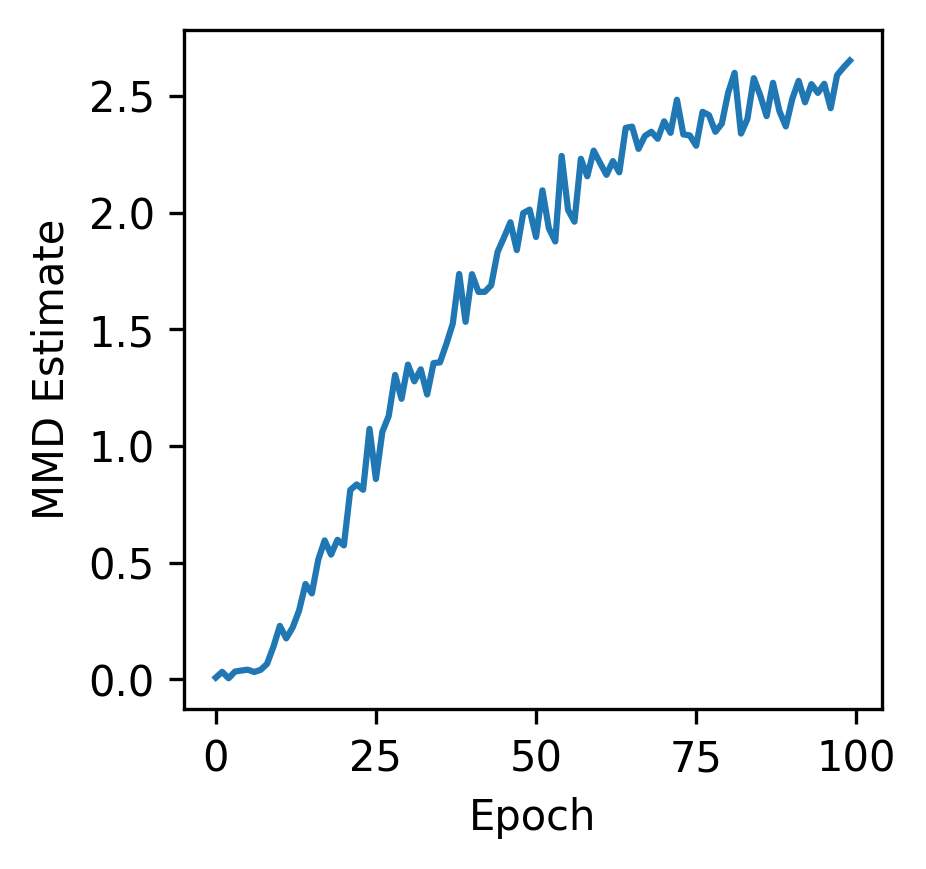

In [103]:
plt.figure(dpi=300).set_size_inches(3, 3)
plt.plot(mmd_fit.loss_iters)
plt.xlabel("Epoch")
plt.ylabel("MMD Estimate")

In [104]:
%matplotlib inline
#Make animation of fitting process
from matplotlib.animation import FuncAnimation
from IPython import display

fig, axs = plt.subplots(1, 3)
#fig.set_dpi(100)
fig.set_size_inches(18, 6)
plt.suptitle("Sample-baseb Fit")

skip_N = 10
def update(frame):
    mmd_fit_grammar.load_state_dict(mmd_fit.grammar_iters[frame])
    for ax in axs:
        ax.cla()
    make_figure_for_grammar(mmd_fit_grammar, axs, N=10)
    plt.suptitle("Sample-based fit, iter %02d" % frame)
    for ax in axs:
        ax.set_xlim([-8, 8.])
        ax.set_ylim([0., 0.7])
ani = FuncAnimation(fig, update, frames=range(0, len(mmd_fit.grammar_iters), skip_N), blit=False, interval=250.)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

One shot fit rule probs:  tensor([0.4000, 0.4000, 0.2000], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-5., -5., -5.], requires_grad=True) +/- tensor([1.0000, 1.5000, 3.5000], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([5., 5., 5.], requires_grad=True) +/- tensor([1.2500, 0.2500, 0.2500], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([-2.,  0.,  2.], requires_grad=True) +/- tensor([1.0000, 2.0000, 1.5000], grad_fn=<AddBackward0>)
One shot fit rule probs:  tensor([0.4000, 0.4000, 0.2000], grad_fn=<DivBackward0>)
One shot-fit Mode 0: Parameter containing:
tensor([-5., -5., -5.], requires_grad=True) +/- tensor([1.0000, 1.5000, 3.5000], grad_fn=<AddBackward0>)
One shot-fit Mode 1: Parameter containing:
tensor([5., 5., 5.], requires_grad=True) +/- tensor([1.2500, 0.2500, 0.2500], grad_fn=<AddBackward0>)
One shot-fit Mode 2: Parameter containing:
tensor([-2.,  0.,  2.], requires_grad=True) +/- tensor([1